# Import Modules

In [ ]:
import os

!git clone https://github.com/m-zayan/tfrecord-handler.git

os.chdir('/content/tfrecord-handler/')

Cloning into 'tfrecord-handler'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 35 (delta 13), reused 35 (delta 13), pack-reused 0
Unpacking objects: 100% (35/35), done.


In [ ]:
from glob import glob

from IPython.display import display
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import tensorflow as tf

# handler
from tfrecord_handler.io import TfRecordWriter, TfRecordReader

# Download dataset

In [ ]:
url = 'https://www.ece.nus.edu.sg/stfpage/elepv/NUS-HandSet/NUS-Hand-Posture-Dataset-II.zip'
fname = 'NUS-Hand-Posture-Dataset-II.zip'

tf.keras.utils.get_file(fname, 
                        url, 
                        extract=True, 
                        archive_format='zip')

path = '/root/.keras/datasets/NUS Hand Posture dataset-II/Hand Postures'

77234176/77233719 [==============================] - 11s 0us/step


# Files as dataframe

In [ ]:
data = {'image': os.listdir(path)}

# set an invaild path - failure_examples

data['image'].append('test_invalid/path/image_1.png')
data['image'].append('test_invalid/path/image_2.png')

data = pd.DataFrame(data)

data.head(2)

,image
0,j (105).jpg
1,f (187).jpg


# Test TfRecordWriter

In [ ]:
if not os.path.exists('../train'):
  os.mkdir('../train')

In [ ]:
def as_grayscale(image):

  return tf.image.rgb_to_grayscale(image).numpy()

In [ ]:
writer = TfRecordWriter(shape=(256, 256),
                        n_records=3, 
                        image_ext='.jpg',
                        quality=100,
                        failure_ignore=True, 
                        cache_warnings=True) 

"""
failure_ignore = True, ignore raising errors, 
and get warning message instead 
in case of failed in writing an example, (ex. reading a corrupted image) or non-image extension, --> .db
"""

print()

In [ ]:
from_dir = path
to_dir = '../train'

dtype = {'image': bytes}
func = {'image': as_grayscale}

# from_dataframe
writer.from_dataframe(dataframe=data, 
                      dtypes=dtype, 
                      image_key='image',
                      pref_fname='train', 
                      from_dir=from_dir, 
                      to_dir=to_dir, 
                      has_ext=True, 
                      func=func, 
                      inplace=False)

 failure_count: 1


 failure_count: 3


In [ ]:
print('failure_examples - index :', writer.failure_examples.keys())

failure_examples - index : dict_keys([878, 2001, 2002])


In [ ]:
for key, value in writer.failure_examples.items():
  print(key, value)

878 ValueError("Failed to read an image\n, image_path :/root/.keras/datasets/NUS Hand Posture dataset-II/Hand Postures/Thumbs.db\nOpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'\n",)
2001 ValueError("Failed to read an image\n, image_path :/root/.keras/datasets/NUS Hand Posture dataset-II/Hand Postures/test_invalid/path/image_1.png\nOpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'\n",)
2002 ValueError("Failed to read an image\n, image_path :/root/.keras/datasets/NUS Hand Posture dataset-II/Hand Postures/test_invalid/path/image_2.png\nOpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'\n",)


# Test TfRecordReader

In [ ]:
trainRec = glob('../train/*')
print(trainRec)

['../train/train_1.tfrec', '../train/train_0.tfrec', '../train/train_2.tfrec']


In [ ]:
feature_dtype = {'image': 'bytes'}

processing_func = {'image': lambda x: x / 255.0}

reader = TfRecordReader(features_dtype=feature_dtype, 
                        image_key='image', 
                        tfrecord_shape=(256, 256, 1), 
                        shape=(128, 128), 
                        channels=1, 
                        func=processing_func)

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

ignore_order = tf.data.Options()
ignore_order.experimental_deterministic = False

In [ ]:
tfData = tf.data.TFRecordDataset(trainRec, num_parallel_reads=AUTOTUNE)
tfData = tfData.with_options(ignore_order)

# reader
tfData = tfData.map(reader.read_tfrecord, num_parallel_calls=AUTOTUNE)
tfData = tfData.batch(32)

In [ ]:
x = tfData.as_numpy_iterator().next()[0]
print(x.shape)

(32, 128, 128, 1)


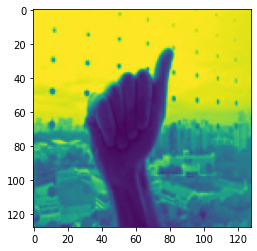

In [ ]:
plt.imshow(x[0][:, :, 0])
plt.show()